In [1]:
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import keras
import os

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input


#model = keras.saving.load_model("AD_Loop_base.keras")

In [2]:
import pandas as pd

data_df = pd.read_csv("training_mixed_set/training_mixed_frames_labels.csv")
data_df.head()
data_df["frame_id"] = data_df["frame_id"].astype(str)
for i,name in enumerate(data_df["frame_id"]):
    data_df.loc[i,"frame_id"] = "training_mixed_set/unlabeled_set/"+ (name).zfill(6) + "_512_512.jpg"
  # labels["frame_id"].iloc[i] = str(name).zfill(6)
# data_df["label"].unique()

data_df["label"] = data_df["label"].astype(str)
for i,lab in enumerate(data_df["label"]):
    if lab == str(0):
        data_df.loc[i,"label"] = "Normal"
    else:
        data_df.loc[i,"label"] = "Anomaly"

In [4]:
envs = pd.read_csv("metadata/training_mixed_set_frames_envs.csv")

In [16]:
env_df = envs[envs["env"] == 1]

In [14]:
env_df.loc[:,"frame_id"] = (env_df.loc[:,"frame_id"]).astype(str)

C:\Users\anton\AppData\Local\Temp\ipykernel_54280\2980095968.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['0' '1' '2' ... '119149' '119150' '119151']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  env_df.loc[:,"frame_id"] = (env_df.loc[:,"frame_id"]).astype(str)


In [17]:
env1_list = []
for name in env_df["frame_id"]:
    env1_list.append("training_mixed_set/unlabeled_set/"+ (str(name)).zfill(6) + "_512_512.jpg")

In [18]:
subdata_df = data_df[data_df['frame_id'].isin(env1_list)]
subdata_df.head()

,frame_id,label
0,training_mixed_set/unlabeled_set/000000_512_51...,Anomaly
1,training_mixed_set/unlabeled_set/000001_512_51...,Anomaly
2,training_mixed_set/unlabeled_set/000002_512_51...,Anomaly
3,training_mixed_set/unlabeled_set/000003_512_51...,Anomaly
4,training_mixed_set/unlabeled_set/000004_512_51...,Anomaly


In [19]:
def preprocess(image):
    return cv2.resize(tf.keras.applications.vgg19.preprocess_input(image), (512, 512))

def low_res(image):
    return preprocess(image)[0::12,0::12]

def preprocess_predict(image):
    return np.expand_dims(preprocess(image),axis=0)

In [20]:
class utils:
    @staticmethod
    def preprocess(image):
        # return image
        return cv2.resize(image, (224, 224))

    @staticmethod
    def low_res(image):
        return utils.preprocess(image)[0::8, 0::8]

    @staticmethod
    def preprocess_predict(image):
        return np.expand_dims(utils.low_res(utils.to_grayscale(image)),axis=2)
        return np.expand_dims(utils.preprocess(tf.keras.applications.vgg19.preprocess_input(image)), axis=0)
    
    @staticmethod
    def acquire_image(path):
        return cv2.imread(path,1)
    
    @staticmethod
    def to_grayscale(im):
        return (cv2.cvtColor(im, cv2.COLOR_BGR2GRAY))
    

In [21]:
def build_autoencoder(neurons_in=28, act_function="linear", optimizer="adam", hidden_layers=0):
    # Input layer
    input_layer = Input(shape=(784,))

    encoded = Dense(300, activation='relu', name='hidden_1')(input_layer)
    # Bottleneck layer
    # encoded = Dense(2, activation='relu', name='bottleneck')(hidden_1)
    # hidden_2 = Dense(neurons_in, activation='relu', name='hidden_2')(encoded)

    # Output layer
    decoded = Dense(784, activation=act_function, name='decoded')(encoded)

    # Create the model
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(loss="mse", optimizer=optimizer)

    return autoencoder

In [80]:
subdata_df.to_pickle("subdata_df.pkl")

In [22]:
subdata_df["label"].value_counts(normalize=True)

label
Anomaly    0.710543
Normal     0.289457
Name: proportion, dtype: float64

In [23]:
normal_df = subdata_df[subdata_df["label"] == "Normal"]

In [68]:
import sklearn
from sklearn.model_selection import train_test_split
normal_df = subdata_df[subdata_df["label"] == "Normal"]
_,sub_normal_df = train_test_split(normal_df, test_size=0.5, shuffle=True, random_state=42)

In [69]:
import sklearn
from sklearn.model_selection import train_test_split
anormal_df = subdata_df[subdata_df["label"] == "Anomaly"]
_,sub_anormal_df = train_test_split(anormal_df, test_size=0.5, shuffle=True, random_state=42)

In [70]:
tot_data = np.array([utils.preprocess_predict(utils.acquire_image(path)).reshape(-1,1) for path in sub_normal_df['frame_id']])
tot_y = np.array([1 if label == 'Anomaly' else 0 for label in sub_normal_df['label']])

In [71]:
import sklearn
from sklearn.model_selection import train_test_split
#Splitting the image_df into training and validation dataframe, shuffling the data and maitaining the ratio between classes
X_train, X_rem, y_train, y_rem = train_test_split(tot_data, tot_y, test_size=0.2, shuffle=True, random_state=42)
X_val,X_test,y_val, y_test = train_test_split(X_rem,y_rem, test_size=0.5, shuffle=True, random_state=42)

In [72]:
tot_data = np.array([utils.preprocess_predict(utils.acquire_image(path)).reshape(-1,1) for path in sub_anormal_df['frame_id']])
tot_y = np.array([1 if label == 'Anomaly' else 0 for label in sub_anormal_df['label']])

In [73]:
X_test = np.concatenate([tot_data,X_test])
y_test = np.concatenate([tot_y,y_test])

In [74]:
X_train = np.reshape(X_train,(-1,784))
X_val = np.reshape(X_val,(-1,784))
X_test = np.reshape(X_test,(-1,784))

In [75]:
len(X_train), len(X_val), len(X_test)

(6262, 783, 19998)

In [76]:
from datetime import datetime
name = datetime.now().strftime(f"models/AE_vaniglia.keras")
ae = build_autoencoder()
callbacks = [
keras.callbacks.ModelCheckpoint(
    filepath = name,
    save_best_only=True,
    verbose=0,
    monitor="val_loss"),
keras.callbacks.EarlyStopping(  
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    restore_best_weights=True
)
]

history = ae.fit(X_train,X_train,
            validation_data = (X_val,X_val),
            epochs=5000,
            batch_size=32,
            verbose=1,
            callbacks=callbacks
)

Epoch 1/5000
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2367.9565 - val_loss: 391.4411
Epoch 2/5000
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 374.0543 - val_loss: 309.2917
Epoch 3/5000
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 305.3967 - val_loss: 264.5005
Epoch 4/5000
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 257.2429 - val_loss: 234.3906
Epoch 5/5000
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 224.5216 - val_loss: 209.6608
Epoch 6/5000
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 204.7776 - val_loss: 187.4335
Epoch 7/5000
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 188.3398 - val_loss: 171.5013
Epoch 8/5000
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 171.7315 - val_loss: 159.8530
Epoch 9/5000
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 161.4517 - val_loss: 148.7204
Epoch 10/5000
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 149.2577 - val_loss: 142.2346
Epoch 11/5000
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 140.0508 - val_

In [77]:
from sklearn.metrics import mean_squared_error
mean_squared_error(X_train[0].reshape(-1,784),ae.predict(X_train[0].reshape(1,784)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


36.50467300415039

In [78]:
from sklearn.metrics import mean_squared_error
mean_squared_error(X_val[1].reshape(-1,784),ae.predict(X_val[1].reshape(1,784)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


49.79020309448242

In [98]:
from sklearn.metrics import mean_squared_error
mean_squared_error(X_test[-1].reshape(-1,784),ae.predict(X_test[-1].reshape(1,784)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


45.82041

In [99]:
train_error = []
for sample in X_train:
    train_error.append(mean_squared_error(sample.reshape(-1,784),ae.predict(sample.reshape(1,784),verbose=0)))

In [102]:
train_error_ = np.square(X_train - ae.predict(X_train))
train_error_ = np.mean(train_error_,axis=1)

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [101]:
#th = np.median(train_error) + 1*np.std(train_error)
#th
th = np.percentile(train_error,20)
th

43.535003662109375

In [221]:
th = np.percentile(train_error_,80)
th

43.535010528564456

In [125]:
classes = []
test_errors = []
for sample in X_test:
    error = mean_squared_error(sample.reshape(-1,784),ae.predict(sample.reshape(1,784),verbose=0))
    test_errors.append(error)
    if error > th:
        classes.append(1)
    else:
        classes.append(0)

KeyboardInterrupt: 

In [136]:
y_pred_test = ae.predict(X_test)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [137]:
error = np.square(X_test - y_pred_test)

In [138]:
error = np.mean(error,axis=1)

In [139]:
error.shape

(8000,)

In [140]:
error

array([166.8585  , 188.34729 , 476.21484 , ...,  46.771805,  54.97979 ,
        45.82041 ], dtype=float32)

In [198]:
y_pred_class = (error > th).astype(int)

In [199]:
y_pred_class

array([1, 1, 1, ..., 0, 0, 0])

In [200]:
y_test

array([1, 1, 1, ..., 0, 0, 0])

In [201]:
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix
precision_score(y_test,y_pred_class)

0.988565205554043

In [202]:
recall_score(y_test,y_pred_class)

0.9448347645068956

In [203]:
f1_score(y_test,y_pred_class)

0.966205428419372

In [204]:
confusion_matrix(y_test,y_pred_class)

array([[ 230,   84],
       [ 424, 7262]])

In [213]:
tn = confusion_matrix(y_test,y_pred_class)[0,0]
tn

230

In [214]:
fn = confusion_matrix(y_test,y_pred_class)[1,0]
fn

424

In [215]:
tp = confusion_matrix(y_test,y_pred_class)[1,1]
tp

7262

In [216]:
fp = confusion_matrix(y_test,y_pred_class)[0,1]
fp

84

In [217]:
tp/(tp + fp)

0.988565205554043

In [218]:
tp/(tp+fn)

0.9448347645068956

In [219]:
tn/(tn+fn)

0.3516819571865443

In [220]:
tn/(tn+fp)

0.732484076433121

In [184]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_class))

              precision    recall  f1-score   support

           0       0.35      0.73      0.48       314
           1       0.99      0.94      0.97      7686

    accuracy                           0.94      8000
   macro avg       0.67      0.84      0.72      8000
weighted avg       0.96      0.94      0.95      8000



In [27]:
im = utils.acquire_image(data_df.loc[0,"frame_id"])

In [ ]:
im_gay = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

In [54]:
im_gay = utils.to_grayscale(im)

In [89]:
im = utils.acquire_image(data_df.loc[200,"frame_id"])
im_gay = utils.to_grayscale(im)

In [93]:
utils.low_res(im_gay).shape

(28, 28)

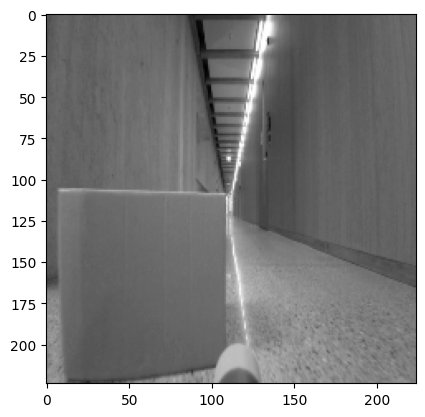

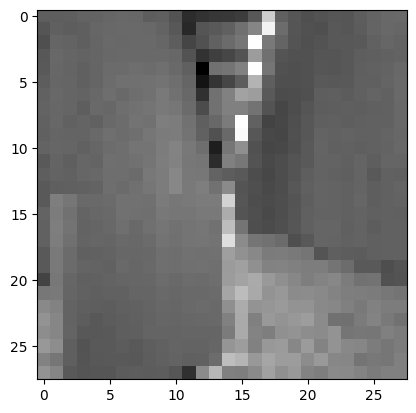

In [124]:
im = utils.acquire_image(data_df.loc[200,"frame_id"])
im_gay = utils.to_grayscale(im)
plt.imshow(utils.preprocess(im_gay),cmap="gray")
plt.show()
plt.imshow(utils.low_res(im_gay),cmap="gray")
plt.show()

In [45]:
im_gay.shape

(512, 512, 1)

(1, 224, 224, 1)

In [64]:
import numpy as np

prob = model.predict(utils.preprocess_predict(im))
label = int(prob.item() >= 0.5) 
print(label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
0


In [69]:
images = data_df["frame_id"].to_list()

In [65]:
import time
import datetime
class ADController:
    def __init__(self, model, cooldown=120, duration=360, dt = 0.1):
        self.CNN_model = model
        # self.SNN_model = low_res_model
        self.dt = dt
        self.cooldown = cooldown
        self.last_called = 0
        self.CNN_call_history = []
        self.SNN_call_history = []
        self.duration = duration
        self.time = 0

    def start_loop(self, data):
        print("Starting Anomaly Detection loop...")
        while self.time < self.duration:
            file_path = random.choice(data)
            img = cv2.imread(file_path)
            check = self.SNN_pred(img)
            # print(f"check: {check}")
            correct_label = self.infer(utils.preprocess_predict(img), check)
            if check:
                self.SNN_update(correct_label)
            self.time += self.dt

    def SNN_pred(self, data):
        img = utils.low_res(data)
        #time.sleep(0.01) #simulo inferenza SNN
        self.time += self.dt #Facciamo che un'inferenza dura un dt (che poi così dovrebbe essere)
        self.update_last_call(0)
        return 1 if np.random.exponential(scale = 0.15) > 1  else 0

    def SNN_update(self, prob):
        # print(f"label : {prob}")
        label = int(prob.item() >= 0.5)
        self.time += self.dt #Stessa cosa per l'update. In realtà le cose dovrebbero avvenire in "real time", dunque in parallelo.
                             #poi casomai giochiamo coi thread
        # print(f"label : {label}")

    def infer(self, data, check):
        current_time = self.time
        if check:
            self.update_last_call(1)
            print(f"Inferenza vera.")
            return self.CNN_model.predict(data,  verbose=0)
        elif self.time - self.last_called >= self.cooldown:
            self.update_last_call(1)
            print(f"Inferenza di routine.")
            return self.CNN_model.predict(data, verbose=0)

    def update_last_call(self, flag):
        current_time = self.time
        self.update_call_history(current_time,flag)
        if flag:
            print(f"Time since last call: {current_time - self.last_called:.2f} seconds")
            self.last_called = current_time

    def update_call_history(self, time, flag):
        if flag:
            self.CNN_call_history.append(time)
        else:
            self.SNN_call_history.append(time)


In [70]:
controller = ADController(model,cooldown=30,duration=100, dt=0.1)
images = data_df["frame_id"].to_list()
controller.start_loop(images)

Starting Anomaly Detection loop...
Time since last call: 30.10 seconds
Inferenza di routine.
Time since last call: 30.00 seconds
Inferenza di routine.
Time since last call: 30.20 seconds
Inferenza di routine.


In [15]:
len(controller.SNN_call_history)

501

In [16]:
len(controller.CNN_call_history) 

3

In [17]:
for timestamp in controller.CNN_call_history:
    print(datetime.datetime.fromtimestamp(timestamp).strftime('%c'))

Thu Jan  1 01:00:30 1970
Thu Jan  1 01:01:00 1970
Thu Jan  1 01:01:30 1970


In [18]:
for timestamp in controller.SNN_call_history:
    print(datetime.datetime.fromtimestamp(timestamp).strftime('%c'))

Thu Jan  1 01:00:00 1970
Thu Jan  1 01:00:00 1970
Thu Jan  1 01:00:00 1970
Thu Jan  1 01:00:00 1970
Thu Jan  1 01:00:00 1970
Thu Jan  1 01:00:01 1970
Thu Jan  1 01:00:01 1970
Thu Jan  1 01:00:01 1970
Thu Jan  1 01:00:01 1970
Thu Jan  1 01:00:01 1970
Thu Jan  1 01:00:02 1970
Thu Jan  1 01:00:02 1970
Thu Jan  1 01:00:02 1970
Thu Jan  1 01:00:02 1970
Thu Jan  1 01:00:02 1970
Thu Jan  1 01:00:03 1970
Thu Jan  1 01:00:03 1970
Thu Jan  1 01:00:03 1970
Thu Jan  1 01:00:03 1970
Thu Jan  1 01:00:03 1970
Thu Jan  1 01:00:04 1970
Thu Jan  1 01:00:04 1970
Thu Jan  1 01:00:04 1970
Thu Jan  1 01:00:04 1970
Thu Jan  1 01:00:04 1970
Thu Jan  1 01:00:05 1970
Thu Jan  1 01:00:05 1970
Thu Jan  1 01:00:05 1970
Thu Jan  1 01:00:05 1970
Thu Jan  1 01:00:05 1970
Thu Jan  1 01:00:06 1970
Thu Jan  1 01:00:06 1970
Thu Jan  1 01:00:06 1970
Thu Jan  1 01:00:06 1970
Thu Jan  1 01:00:06 1970
Thu Jan  1 01:00:07 1970
Thu Jan  1 01:00:07 1970
Thu Jan  1 01:00:07 1970
Thu Jan  1 01:00:07 1970
Thu Jan  1 01:00:07 1970
